This notebook is my attempt at developing a DDPG model for stock market investment, training and testing will be done on the DJIA.

Code based on https://github.com/keras-team/keras-io/blob/master/examples/rl/ddpg_pendulum.py and https://arxiv.org/abs/1811.07522 and the DDPG original paper

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import tensorflow as tf
from enviroment import Simulate_Portfolio
from datetime import datetime, timedelta
import keras
import yfinance as yf


Create enviroment and datasets

In [ ]:
training_years = 6
validation_years = 1
testing_years = 1
start_datetime = datetime.now() - timedelta(weeks=52*training_years)
validation_datetime = datetime.now()  - timedelta(weeks=52*validation_years)
testing_datetime = datetime.now() - timedelta(weeks = 52*testing_years)

name = 'GOOG'

porfolio = Simulate_Portfolio(start_datetime)
porfolio.add_investment(name)
initial_state = porfolio.return_state(name)


In [ ]:
df1 = porfolio.investments['GOOG'].history(start = start_datetime, end = datetime.now(), interval = '1d')

df1.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-09-24 00:00:00-04:00,61.578597,61.913308,60.122562,60.523815,31664000,0.0,0.0
2019-09-25 00:00:00-04:00,60.377823,61.990785,60.093271,61.902390,29060000,0.0,0.0
2019-09-26 00:00:00-04:00,61.675938,61.826906,61.194632,61.647633,30760000,0.0,0.0
2019-09-27 00:00:00-04:00,61.728079,61.778235,60.309783,60.838169,27078000,0.0,0.0
2019-09-30 00:00:00-04:00,60.633574,60.883363,60.203022,60.535744,28082000,0.0,0.0


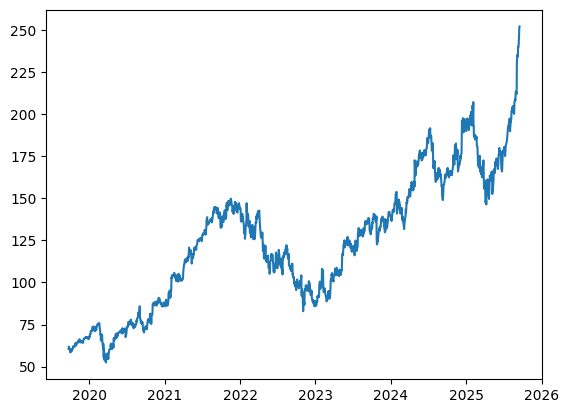

In [ ]:
plt.plot(df1['Close'])

In [ ]:
df1 = df1['Close']

df1.head()

Date
2019-09-24 00:00:00-04:00    60.523815
2019-09-25 00:00:00-04:00    61.902390
2019-09-26 00:00:00-04:00    61.647633
2019-09-27 00:00:00-04:00    60.838169
2019-09-30 00:00:00-04:00    60.535744
Name: Close, dtype: float64

Supporting Functions

In [ ]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)
            
            
def reset_enviroment():
    
    training_years = 6
    validation_years = 1
    testing_years = 1
    start_datetime = datetime.now() - timedelta(weeks=52*training_years)
    validation_datetime = datetime.now()  - timedelta(weeks=52*validation_years)
    testing_years = datetime.now() - timedelta(weeks = 52*testing_years)

    porfolio = Simulate_Portfolio(start_datetime)
    porfolio.add_investment(name)
    initial_state = porfolio.return_state(name)
    
    return initial_state, porfolio

def policy(state, noise_obj, actor):
    sampled_actions = keras.ops.squeeze(actor(state))
    noise = noise_obj()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise


    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, -1, 1)

    return [np.squeeze(legal_action)]

def perform_action(action, porfolio, prev_state):
    # :: action, portfolio, prev_state -> state, reward
    
    prev_net = porfolio.get_portfolio_net()
    
    holdings = prev_state[1]
    balance = prev_state[2]
    
    if 1>= action >= 0:
        value = max(balance, 0) * action + holdings
    elif -1<= action < 0:
        value = holdings * (action+1)
    else:
        raise ValueError(f" Action must be between -1 and 1, action {action} ")
    
   # print(f'Updated value: {value}, action: {action}, state:{prev_state}')
   
   
    try:
        porfolio.update_investment(name, value)
    except:
        raise ValueError(f"Why tf: {value}, action: {action}, state: {prev_state}, 1: {max(balance, 0) * action}, 2: {holdings * (action+1)} ")

    
    porfolio.next_timestep()
    
    
    reward = porfolio.get_portfolio_net() - prev_net
    
   # print(f'Updated state: {porfolio.return_state(name)} with reward: {reward}')

    return porfolio.return_state(name), reward, value - holdings

        
def update_target(target, original, tau):
    target_weights = target.get_weights()
    original_weights = original.get_weights()

    for i in range(len(target_weights)):
        target_weights[i] = original_weights[i] * tau + target_weights[i] * (1 - tau)

    target.set_weights(target_weights)
    

In [ ]:
"""Testing the noise setup"""

OUActionNoise

noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(0.2) * np.ones(1))
noise.reset()
x_vals = []
for _ in range(100):
    x = noise()
    x_vals.append(x[0])

plt.figure(figsize=(10, 4))
plt.plot(x_vals)
plt.title("Ornstein-Uhlenbeck Noise (100 steps, x_initial=1)")
plt.xlabel("Step")
plt.ylabel("Noise Value")
plt.grid(True)
plt.show()


: 

Model Setup

In [ ]:
from keras import layers
from tensorflow.keras.layers import LeakyReLU

num_states = 3
num_actions = 1


def get_actor():

    last_init = keras.initializers.RandomUniform(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(64)(inputs)
    out = LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(64)(out)
    out = LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(64, activation="sigmoid")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    outputs = outputs * 1
    model = keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    last_init = keras.initializers.RandomUniform(minval=-0.003, maxval=0.003)

    state_input = layers.Input(shape=(num_states,))
    out = layers.Dense(64)(state_input)
    out = LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(64)(out)
    out = LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(64)(out)
    out = LeakyReLU(alpha=0.1)(out)
    state_out = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Action as input
    action_input = layers.Input(shape=(num_actions,))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through separate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(128)(concat)
    out = LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(128)(out)
    out = LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(128, activation="sigmoid")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = keras.Model([state_input, action_input], outputs)

    return model





Training Hyperparams

In [ ]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1), theta=0.2)

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())


# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = keras.optimizers.Adam(critic_lr)
actor_optimizer = keras.optimizers.Adam(actor_lr)


# Discount factor for future rewards
gamma = 0.90
# Used to update target networks
tau = 0.005

c:\Users\morus\anaconda3\envs\tf\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Buffer

In [ ]:
class Buffer:
    def __init__(self, models, buffer_capacity=100_000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    def record(self, obs_tuple):
        
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1
        
    @tf.function
    def update(
        self,
        state_batch,
        action_batch,
        reward_batch,
        next_state_batch,
    ):
        
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training = True)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions], training = True)
            
            critic_value = critic_model([state_batch, action_batch], training = True)
            critic_loss = keras.ops.mean(keras.ops.square(y - critic_value))
            
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(zip(critic_grad, critic_model.trainable_variables))
        
        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training = True)
            critic_value = critic_model([state_batch, actions], training = True)
            actor_loss = -keras.ops.mean(critic_value)
            
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        
    def learn(self):
        
        record_range = min(self.buffer_counter, self.buffer_capacity)
        
        batch_indices = np.random.choice(record_range, self.batch_size)
        state_batch = keras.ops.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = keras.ops.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = keras.ops.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = keras.ops.cast(reward_batch, dtype="float32")
        next_state_batch = keras.ops.convert_to_tensor(
            self.next_state_buffer[batch_indices]
        )

        self.update(state_batch, action_batch, reward_batch, next_state_batch)




Main

In [ ]:
total_episodes = 20
print(f"Training run from {start_datetime} to {validation_datetime} with {total_episodes} episodes")


Training run from 2019-09-24 19:39:23.678442 to 2024-09-17 19:39:23.678442 with 100 episodes


In [ ]:

buffer = Buffer(50000, 64)

# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

start_time = start_datetime
end_time = validation_datetime
ep_profit = []
all_states = []
all_actions = []
    
for ep in range(total_episodes):
    
    ep_start = datetime.now()
    prev_state, porfolio = reset_enviroment()
    episodic_reward = 0
    step = 0
    
    episodic_actions = []
    episodic_val_diff = []
    episodic_timesteps = []
    episodic_full_state = []

    print(f"Starting episode: {ep}, with datetime {porfolio.datetime.strftime('%d-%m-%Y')}, ending at {end_time.strftime('%d-%m-%Y')}, state: {prev_state}")
    
    while porfolio.datetime < end_time:
        
        tf_prev_state = keras.ops.expand_dims(
            keras.ops.convert_to_tensor(prev_state), 0
        )
        
        action = policy(tf_prev_state, ou_noise, actor_model)
        
        state, reward, value_change = perform_action(action[0], porfolio, prev_state)
        
                
        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward
        
        buffer.learn()

        update_target(target_actor, actor_model, tau)
        update_target(target_critic, critic_model, tau)

        episodic_actions.append(action)
        episodic_val_diff.append(value_change)
        episodic_full_state.append([prev_state])

        prev_state = state 

        step+=1

    all_states.append(episodic_full_state)
    ep_reward_list.append(episodic_reward)
    
    ep_profit.append(porfolio.calc_profit())
    
    avg_reward = np.mean(ep_reward_list[-40:])
    
    ep_end = datetime.now()
    elapsed = ep_end - ep_start
    minutes, seconds = divmod(elapsed.total_seconds(), 60)
    try:
        print(f"Episode {ep}, with avarage {episodic_reward/step}, time: {int(minutes)}m {int(seconds)}s, with {step} timesteps")
    except:
        print(f"Episode {ep}, with avarage {episodic_reward, step}, time: {int(minutes)}m {int(seconds)}s, with {step} timesteps")

    print(f"Episode profit -- start: {porfolio.init_balane}, end: {porfolio.get_portfolio_net()}, profit: {porfolio.calc_profit()}")
    print(f"Episode actions -- avg action: {np.mean(episodic_actions)}, latest:{np.mean(episodic_actions[-40:])}")
    print(f"Episodic value changes -- reward: {episodic_reward} avg change: {np.mean(episodic_val_diff)}, latest:{np.mean(episodic_val_diff[-40:])} \n")
    print(f"Ending state: {state}, datetime: {porfolio.datetime.strftime('%d-%m-%Y')}\n")
    avg_reward_list.append(avg_reward)
    all_actions.append(episodic_actions)
    


Starting episode: 0, with datetime 24-09-2019, ending at 17-09-2024, state: [ 60.52382278   0.         100.        ]
Episode 0, with avarage 0.04837326951527742, time: 0m 21s, with 1253 timesteps
Episode profit -- start: 100.0, end: 160.6117067026426, profit: 60.61170670264261
Episode actions -- avg action: 1.0, latest:1.0
Episodic value changes -- reward: 60.61170670264261 avg change: 0.07980845969672772, latest:0.0 

Starting episode: 1, with datetime 24-09-2019, ending at 17-09-2024, state: [ 60.52381897   0.         100.        ]
Episode 1, with avarage 0.0483724686879866, time: 0m 18s, with 1253 timesteps
Episode profit -- start: 100.0, end: 160.6107032660472, profit: 60.61070326604721
Episode actions -- avg action: 1.0, latest:1.0
Episodic value changes -- reward: 60.61070326604721 avg change: 0.07980845969672769, latest:0.0 

Starting episode: 2, with datetime 24-09-2019, ending at 17-09-2024, state: [ 60.52382278   0.         100.        ]
Episode 2, with avarage 0.048372730781

In [ ]:
actor_model.save_weights("./params/actor_weights.weights.h5")
critic_model.save_weights("./params/critic_weights.weights.h5")

In [ ]:
# training_years = 6
# validation_years = 1
# testing_years = 1
# start_datetime = datetime.now() - timedelta(weeks=52*training_years)
# validation_datetime = datetime.now()  - timedelta(weeks=52*validation_years)
# testing_datetime = datetime.now() - timedelta(weeks = 52*testing_years)

start_datetime = validation_datetime


name = 'GOOG'

porfolio = Simulate_Portfolio(start_datetime)
porfolio.add_investment(name)
initial_state = porfolio.return_state(name)

In [ ]:

    

training_portfolio = Simulate_Portfolio(validation_datetime)
training_portfolio.add_investment(name)
initial_state = training_portfolio.return_state(name)
prev_state = initial_state
porfolio = training_portfolio
episodic_reward = 0
step = 0

episodic_actions = []
episodic_val_diff = []
episodic_timesteps = []
episodic_full_state = []

print(f"Starting episode: {ep}, with datetime {porfolio.datetime.strftime('%d-%m-%Y')}, ending at {end_time.strftime('%d-%m-%Y')}, state: {prev_state}")

while porfolio.datetime < end_time:

    tf_prev_state = keras.ops.expand_dims(
        keras.ops.convert_to_tensor(prev_state), 0
    )
    
    action = policy(tf_prev_state, ou_noise, actor_model)
    
    state, reward, value_change = perform_action(action[0], porfolio, prev_state)
    
            
    buffer.record((prev_state, action, reward, state))
    episodic_reward += reward
    
    # buffer.learn()

    # update_target(target_actor, actor_model, tau)
    # update_target(target_critic, critic_model, tau)

    episodic_actions.append(action)
    episodic_val_diff.append(value_change)
    episodic_full_state.append([prev_state])

    prev_state = state 
    
    avg_reward = np.mean(ep_reward_list[-40:])
    
    ep_end = datetime.now()
    elapsed = ep_end - ep_start
    minutes, seconds = divmod(elapsed.total_seconds(), 60)
    try:
        print(f"Episode {ep}, with avarage {episodic_reward/step}, time: {int(minutes)}m {int(seconds)}s, with {step} timesteps")
    except:
        print(f"Episode {ep}, with avarage {episodic_reward, step}, time: {int(minutes)}m {int(seconds)}s, with {step} timesteps")

    print(f"Episode actions -- avg action: {np.mean(episodic_actions)}, latest:{np.mean(episodic_actions[-40:])}")
    print(f"Episodic value changes -- reward: {episodic_reward} avg change: {np.mean(episodic_val_diff)}, latest:{np.mean(episodic_val_diff[-40:])} \n")
    
    avg_reward_list.append(avg_reward)

Starting episode: 99, with datetime 17-09-2024, ending at 09-09-2025, state: [159.58155823   0.         100.        ]
Episode 99, with avarage inf, time: 0m 18s, with 0 timesteps
Episode actions -- avg action: 1.0, latest:1.0
Episodic value changes -- reward: 0.3306739876521476 avg change: 100.0, latest:100.0 

Episode 99, with avarage inf, time: 0m 18s, with 0 timesteps
Episode actions -- avg action: 1.0, latest:1.0
Episodic value changes -- reward: 0.3306739876521476 avg change: -0.1653369938260738, latest:-0.1653369938260738 

Episode 99, with avarage inf, time: 0m 18s, with 0 timesteps
Episode actions -- avg action: 1.0, latest:1.0
Episodic value changes -- reward: 1.1911278962687817 avg change: 33.333333333333336, latest:33.333333333333336 

Episode 99, with avarage inf, time: 0m 18s, with 0 timesteps
Episode actions -- avg action: 1.0, latest:1.0
Episodic value changes -- reward: 1.1911278962687817 avg change: -0.2977819740671954, latest:-0.2977819740671954 

Episode 99, with ava

C:\Users\morus\AppData\Local\Temp\ipykernel_49496\2785358604.py:47: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Episode {ep}, with avarage {episodic_reward/step}, time: {int(minutes)}m {int(seconds)}s, with {step} timesteps")


Episode 99, with avarage inf, time: 0m 18s, with 0 timesteps
Episode actions -- avg action: 1.0, latest:1.0
Episodic value changes -- reward: 12.368887077776208 avg change: -0.26888884951687503, latest:-0.2706014900006096 

Episode 99, with avarage inf, time: 0m 18s, with 0 timesteps
Episode actions -- avg action: 1.0, latest:1.0
Episodic value changes -- reward: 7.242487310233642 avg change: 2.127659574468084, latest:0.0 

Episode 99, with avarage inf, time: 0m 18s, with 0 timesteps
Episode actions -- avg action: 1.0, latest:1.0
Episodic value changes -- reward: 7.242487310233642 avg change: -0.1508851522965339, latest:-0.1293585561508479 

Episode 99, with avarage inf, time: 0m 18s, with 0 timesteps
Episode actions -- avg action: 1.0, latest:1.0
Episodic value changes -- reward: 9.083814394611593 avg change: 2.0408163265306127, latest:0.0 

Episode 99, with avarage inf, time: 0m 18s, with 0 timesteps
Episode actions -- avg action: 1.0, latest:1.0
Episodic value changes -- reward: 9.0

In [ ]:
print(episodic_full_state)

[[array([159.58155823,   0.        , 100.        ])], [array([160.10925293, 100.33067399,   0.        ])], [array([162.52867126,   0.        , 100.33067399])], [array([163.92254639, 101.1911279 ,   0.        ])], [array([162.35942078,   0.        , 101.1911279 ])], [array([162.92692566, 101.54482748,   0.        ])], [array([162.27978516,   0.        , 101.54482748])], [array([163.11610413, 102.06814506,   0.        ])], [array([164.56971741,   0.        , 102.06814506])], [array([166.4614563 , 103.24142459,   0.        ])], [array([167.68611145,   0.        , 103.24142459])], [array([166.58091736, 102.56097579,   0.        ])], [array([166.48136902,   0.        , 102.56097579])], [array([167.82546997, 103.38901022,   0.        ])], [array([163.67366028,   0.        , 103.38901022])], [array([164.97793579, 104.21289205,   0.        ])], [array([162.34942627,   0.        , 104.21289205])], [array([162.46890259, 104.28958448,   0.        ])], [array([163.80307007,   0.        , 104.28958

In [ ]:
print(episodic_full_state)

[[array([159.58155823,   0.        , 100.        ])], [array([160.10925293, 100.33067399,   0.        ])], [array([162.52867126,   0.        , 100.33067399])], [array([163.92254639, 101.1911279 ,   0.        ])], [array([162.35942078,   0.        , 101.1911279 ])], [array([162.92692566, 101.54482748,   0.        ])], [array([162.27978516,   0.        , 101.54482748])], [array([163.11610413, 102.06814506,   0.        ])], [array([164.56971741,   0.        , 102.06814506])], [array([166.4614563 , 103.24142459,   0.        ])], [array([167.68611145,   0.        , 103.24142459])], [array([166.58091736, 102.56097579,   0.        ])], [array([166.48136902,   0.        , 102.56097579])], [array([167.82546997, 103.38901022,   0.        ])], [array([163.67366028,   0.        , 103.38901022])], [array([164.97793579, 104.21289205,   0.        ])], [array([162.34942627,   0.        , 104.21289205])], [array([162.46890259, 104.28958448,   0.        ])], [array([163.80307007,   0.        , 104.28958

In [ ]:
prices = np.array(episodic_full_state)[:,:,0]
holdings = np.array(episodic_full_state)[:,:,1]
balance = np.array(episodic_full_state)[:,:,2]

In [ ]:
print(holdings)

[[  0.        ]
 [100.33067399]
 [  0.        ]
 [101.1911279 ]
 [  0.        ]
 [101.54482748]
 [  0.        ]
 [102.06814506]
 [  0.        ]
 [103.24142459]
 [  0.        ]
 [102.56097579]
 [  0.        ]
 [103.38901022]
 [  0.        ]
 [104.21289205]
 [  0.        ]
 [104.28958448]
 [  0.        ]
 [105.44964239]
 [  0.        ]
 [105.34857226]
 [  0.        ]
 [105.69438395]
 [  0.        ]
 [106.34462034]
 [  0.        ]
 [106.37697243]
 [  0.        ]
 [107.23695693]
 [  0.        ]
 [110.36997443]
 [  0.        ]
 [110.34440971]
 [  0.        ]
 [110.81636567]
 [  0.        ]
 [113.27095036]
 [  0.        ]
 [114.59976736]
 [  0.        ]
 [112.8306226 ]
 [  0.        ]
 [110.62935468]
 [  0.        ]
 [112.36888708]
 [  0.        ]
 [107.24248731]
 [  0.        ]
 [109.08381439]
 [  0.        ]
 [109.21169094]
 [  0.        ]
 [110.80670839]
 [  0.        ]
 [112.77283179]
 [  0.        ]
 [114.18322083]
 [  0.        ]
 [120.2631011 ]
 [  0.        ]
 [118.38006711]
 [  0.  

In [ ]:
print(balance)

[[100.        ]
 [  0.        ]
 [100.33067399]
 [  0.        ]
 [101.1911279 ]
 [  0.        ]
 [101.54482748]
 [  0.        ]
 [102.06814506]
 [  0.        ]
 [103.24142459]
 [  0.        ]
 [102.56097579]
 [  0.        ]
 [103.38901022]
 [  0.        ]
 [104.21289205]
 [  0.        ]
 [104.28958448]
 [  0.        ]
 [105.44964239]
 [  0.        ]
 [105.34857226]
 [  0.        ]
 [105.69438395]
 [  0.        ]
 [106.34462034]
 [  0.        ]
 [106.37697243]
 [  0.        ]
 [107.23695693]
 [  0.        ]
 [110.36997443]
 [  0.        ]
 [110.34440971]
 [  0.        ]
 [110.81636567]
 [  0.        ]
 [113.27095036]
 [  0.        ]
 [114.59976736]
 [  0.        ]
 [112.8306226 ]
 [  0.        ]
 [110.62935468]
 [  0.        ]
 [112.36888708]
 [  0.        ]
 [107.24248731]
 [  0.        ]
 [109.08381439]
 [  0.        ]
 [109.21169094]
 [  0.        ]
 [110.80670839]
 [  0.        ]
 [112.77283179]
 [  0.        ]
 [114.18322083]
 [  0.        ]
 [120.2631011 ]
 [  0.        ]
 [118.38

In [ ]:
print(prices)

[[159.58155823]
 [160.10925293]
 [162.52867126]
 [163.92254639]
 [162.35942078]
 [162.92692566]
 [162.27978516]
 [163.11610413]
 [164.56971741]
 [166.4614563 ]
 [167.68611145]
 [166.58091736]
 [166.48136902]
 [167.82546997]
 [163.67366028]
 [164.97793579]
 [162.34942627]
 [162.46890259]
 [163.80307007]
 [165.62512207]
 [166.17269897]
 [166.01342773]
 [163.79312134]
 [164.33078003]
 [165.07751465]
 [166.09307861]
 [163.76324463]
 [163.81306458]
 [166.26231384]
 [167.60643005]
 [170.39424133]
 [175.37245178]
 [171.93746948]
 [171.89764404]
 [169.93623352]
 [170.66307068]
 [177.55290222]
 [181.48570251]
 [179.07624817]
 [181.17704773]
 [182.5211792 ]
 [179.70349121]
 [176.57719421]
 [173.13226318]
 [176.02957153]
 [178.79745483]
 [176.55726624]
 [168.5025177 ]
 [165.84417725]
 [168.69168091]
 [169.87649536]
 [170.07563782]
 [169.74707031]
 [172.22619629]
 [172.26603699]
 [175.32267761]
 [173.5504303 ]
 [175.72093201]
 [176.52832031]
 [185.9278717 ]
 [196.07502747]
 [193.00495911]
 [190.76

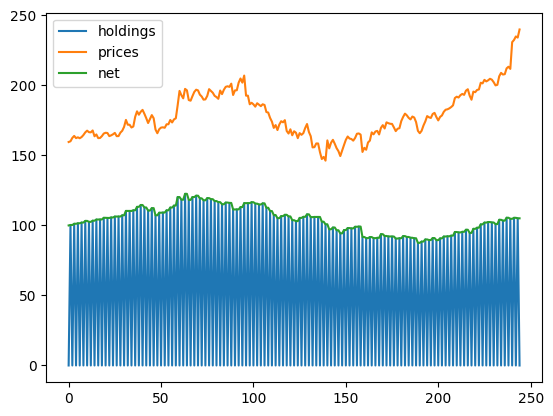

In [ ]:
timestep = list(range(len(holdings)))


plt.plot(timestep, holdings, label = 'holdings')
plt.plot(timestep, prices, label = 'prices')
# plt.plot(timestep, balance, label = 'balance')
plt.plot(timestep, balance + holdings, label = 'net')
plt.legend()

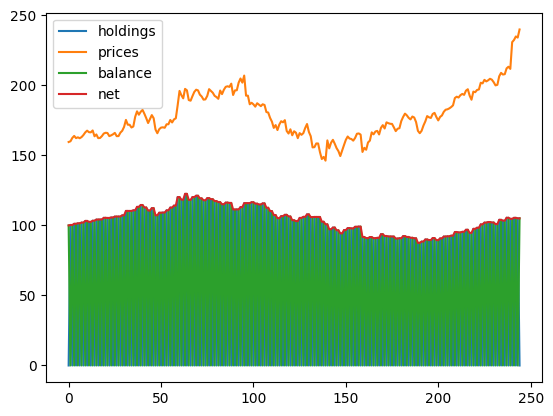

In [ ]:
timestep = list(range(len(holdings)))


plt.plot(timestep, holdings, label = 'holdings')
plt.plot(timestep, prices, label = 'prices')
plt.plot(timestep, balance, label = 'balance')
plt.plot(timestep, balance + holdings, label = 'net')
plt.legend()

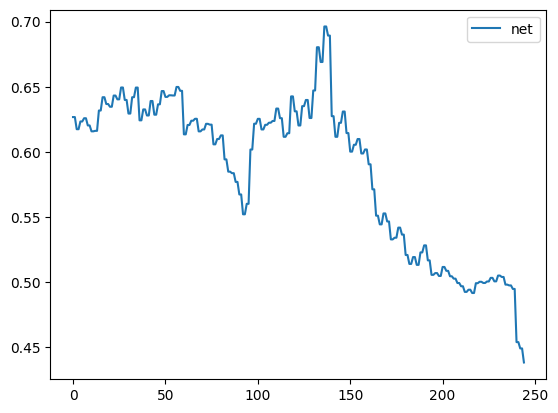

In [ ]:
timestep = list(range(len(holdings)))


plt.plot(timestep, (balance + holdings) / prices, label = 'net')
plt.legend()

This should be increasing not decreasing for a succesful model

In [ ]:
print(episodic_actions)

[[array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)]

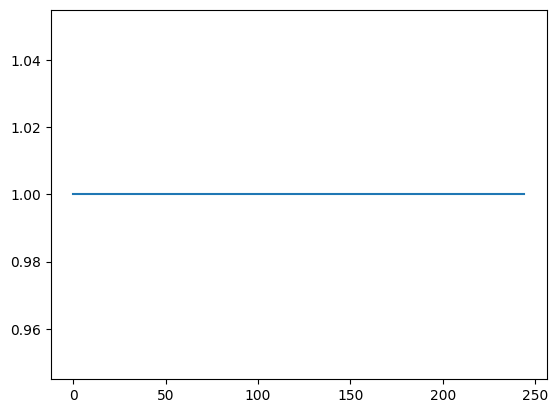

In [ ]:
plt.plot(episodic_actions)